---
title: "COVID Data Analysis"
date: "04/25/23"

mainfont: "Baskerville Old Face"
monofont: "Fira Code"
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from unidecode import unidecode
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(style='whitegrid', rc={'figure.figsize':(16, 4)})

# I want crisp graphics, so we'll output SVG
%config InlineBackend.figure_format = 'svg'


raw = pd.read_csv('../data/raw/raw_base_junio.csv')
cas_ = pd.read_csv('https://raw.githubusercontent.com/andrab/ecuacovid/master/datos_crudos/ecuacovid.csv')

In [2]:
def get_mutaciones(df):

    dums = \
    (df
     .mutaciones
     .str.replace('[()]', '', regex=True)
     .str.get_dummies(sep=',')
     .rename(columns=lambda c: '__' + c)
    )
    
    return pd.concat([df, dums], axis=1)

def tweak_covid(df):
    return (df
     .rename(columns=lambda c:unidecode(c.replace(' ', '_').lower()))
     .drop(index=df[df.Edad.str.contains('months')==True].index)
     .drop(columns=['gisaid_id', 'unnamed:_1', 'fecha_de_subida_a_gisaid'])
     .dropna(subset=['linaje', 'clado', 'mutaciones'])
     .applymap(lambda tx: unidecode(tx.title()) if isinstance(tx, str) else tx)
     .pipe(get_mutaciones)
     .assign(fecha_de_coleccion=lambda df_:pd.to_datetime(df_.fecha_de_coleccion),
             edad=lambda df_:(df_
                              .edad
                              .replace(to_replace=['Unknown', 'M'], value=np.nan)), # neither floats nor int are nullable
             virus_name_unidentified=lambda df_:(df_
                                                 .virus_name
                                                 .str.split('/', expand=True)[2]),
             count_muts=lambda df_:(df_
                                    [[c for c in df_.columns if c not in ['provincia', 'ciudad', 'tipo', 
                                                                          'genero', 'edad', 'linaje', 
                                                                          'clado', 'virus_name', 'mutaciones',
                                                                          'fecha_de_coleccion', 'virus_name_unidentified']]]
                                    .apply(lambda s: s.sum(), axis=1)),
            )
     .drop(columns=['virus_name', 'mutaciones'])
     .set_index('fecha_de_coleccion')
    )

df = tweak_covid(raw)

In [3]:
df

,provincia,ciudad,tipo,genero,edad,linaje,clado,__E_A41V,__E_L73F,__E_R61L,...,__Spike_Y145Del,__Spike_Y145N,__Spike_Y145P,__Spike_Y145T,__Spike_Y248Del,__Spike_Y248F,__Spike_Y449N,__Spike_Y505H,virus_name_unidentified,count_muts
fecha_de_coleccion,,,,,,,,,,,,,,,,,,,,,
2020-03-09,Pichincha,Quito,Hospital,Male,57,B.55,L,0,0,0,...,0,0,0,0,0,0,0,0,Hee-01,1
2020-03-30,Pichincha,Quito,Hospital,Male,27,B.1.1,Gr,0,0,0,...,0,0,0,0,0,0,0,0,Hgsq-Usfq-018,5
2020-03-30,Pichincha,Quito,Hospital,Male,40,B.1.14,O,0,0,0,...,0,0,0,0,0,0,0,0,Hgsq-Usfq-007,18
2020-03-30,Pichincha,Quito,Hospital,Male,39,B.1.14,O,0,0,0,...,0,0,0,0,0,0,0,0,Hgsq-Usfq-010,18
2020-04-17,Los Rios,Babahoyo,Hospital,Female,50,B.1.67,G,0,0,0,...,0,0,0,0,0,0,0,0,Usfq-020,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,Pichincha,Quito,Ambulatorio,Male,42,Ba.2,Gra,0,0,0,...,0,0,0,0,0,0,0,1,Usfq-3477,53
2022-05-28,Pichincha,Quito,Ambulatorio,Male,54,Ba.2,Gra,0,0,0,...,0,0,0,0,0,0,0,1,Usfq-3479,61
2022-05-29,Pichincha,Quito,Ambulatorio,Male,5,Ba.2,Gra,0,0,0,...,0,0,0,0,0,0,0,1,Usfq-3482,51


### Exploring the prevalence of variants

In [4]:
# Which variants have occurred more frequently
from IPython.display import display

with pd.option_context('max_rows', None):
    display(
        (df
         .groupby(['linaje'])
         .agg({'linaje':'count'})
         .rename(columns={'linaje':'Relative Percentage'})
         .apply(lambda s: s / s.sum())
         .sort_values(by='Relative Percentage', ascending=False)
         [:10]
         .style
         .background_gradient(axis=None, vmin=0.03, vmax=0.18, cmap='inferno')
         .format(lambda x: f'{x * 100:.2f}%')
        )     
    )

OptionError: Pattern matched multiple keys

The sars-cov-2 variants *Ba.1.1*, *B.1*, *Ba.1.14*, *B.1.1*, *B.1.1.7* account for aproximately 50% of all sampled sars-cov-2 variants. 

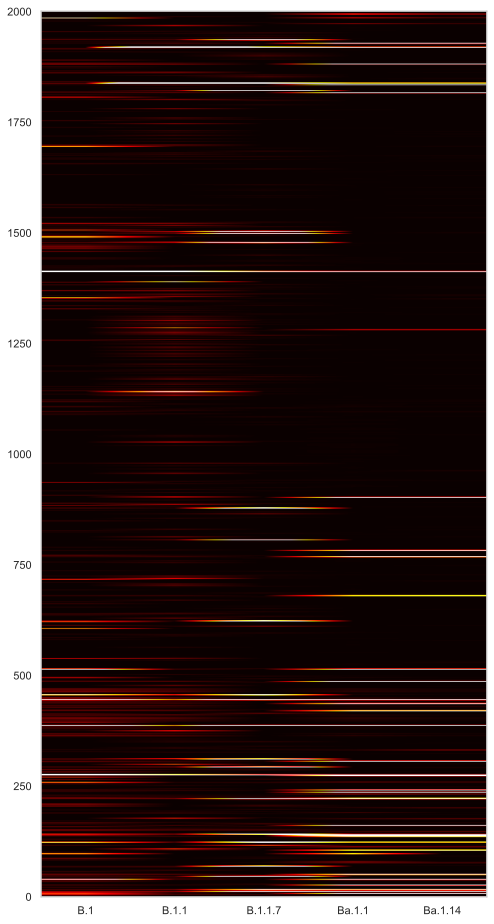

In [ ]:
def plot_heat(df):
    
    fig, ax = plt.subplots(figsize=(8, 16))
    
    heat = ax.imshow(df,
                     cmap='hot',
                     norm='linear',
                     vmin=0,
                     vmax=1,
                     interpolation='bilinear',
                     aspect='auto',
                     extent=[0, df.shape[1], 0, df.shape[0]]
                    )
    
    ax.grid(False)
    ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
    ax.set_xticklabels(['B.1', 'B.1.1', 'B.1.1.7', 'Ba.1.1', 'Ba.1.14'])



(df
 [['linaje'] + [c for c in df.columns if '__' in c]]
 .loc[df.linaje.isin(['Ba.1.1', 'B.1', 'Ba.1.14', 'B.1.1', 'B.1.1.7'])]
 .melt(id_vars='linaje')
 .groupby(['linaje', 'variable'])
 .agg('sum')
 .unstack(level=0)
 ['value']
 .apply(lambda s: (s / s.sum()) * 100, axis=0)
 .pipe(plot_heat)
)

In [ ]:
plt.Axes.set_xticks?

Signature: plt.Axes.set_xticks(self, ticks, labels=None, *, minor=False, **kwargs)
Docstring:
Set the xaxis' tick locations and optionally labels.

If necessary, the view limits of the Axis are expanded so that all
given ticks are visible.

Parameters
----------
ticks : list of floats
    List of tick locations.  The axis `.Locator` is replaced by a
    `~.ticker.FixedLocator`.

    Some tick formatters will not label arbitrary tick positions;
    e.g. log formatters only label decade ticks by default. In
    such a case you can set a formatter explicitly on the axis
    using `.Axis.set_major_formatter` or provide formatted
    *labels* yourself.
labels : list of str, optional
    List of tick labels. If not set, the labels are generated with
    the axis tick `.Formatter`.
minor : bool, default: False
    If ``False``, set the major ticks; if ``True``, the minor ticks.
**kwargs
    `.Text` properties for the labels. These take effect only if you
    pass *labels*. In other cases, ple

### Exploring Infection Waves

In [ ]:
cas_ = \
(cas_
 .assign(created_at=pd.to_datetime(cas_.created_at, dayfirst=True))
 .set_index('created_at')
)

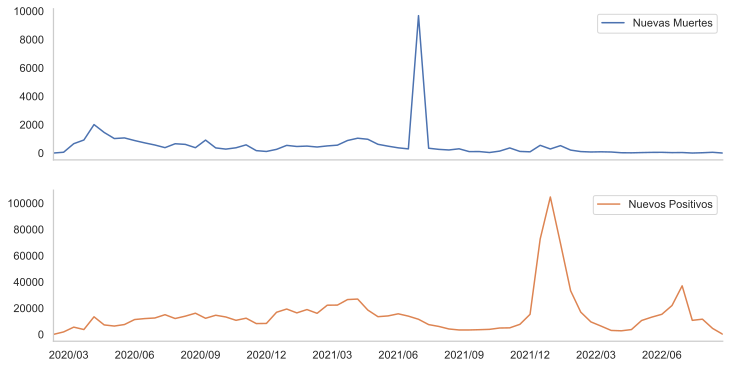

In [ ]:
def remove_nonpositive(df):
    return df[df.ge(0)]

ticks_ = pd.date_range(start = '2020/03/13', end = '2022/09/12', freq = 'q')

axes = \
(cas_
 [['muertes_nuevas', 'positivas_pcr_nuevas']]
 .pipe(remove_nonpositive)
 .resample('2w')
 .sum()
 .plot(
     subplots=True,
     figsize=(12, 6),
     xlabel='',
     xticks=ticks_
 )
)

for ax, label in zip(axes, ['Nuevas Muertes', 'Nuevos Positivos']):
    ax.set_xticklabels(ticks_.format(date_format='%Y/%m'))
    ax.grid(False)
    ax.legend([label])
        
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

The first wave appears to have taken place between April and May of 2020. From the graph, it seems to have been particularly deadly as it presents the second major peak in deaths. It may be due to the fact that not testing was not widespread. The second wave may be place in the first quarter of 2021. In either July or August the number of deaths increases to a suspicous high. Finally, around the first quarter of 2022 there is a new high in cases. After that point cases present another peak but without impacting the death toll. 

### Exploring the lineages that caused the waves

In [ ]:
(df
 .loc['2020/03':'2020/06']
 .groupby(['linaje'])
 .agg({'linaje':'count'})
 .rename(columns={'linaje':'Relative Percentage'})
 .apply(lambda s: s / s.sum())
 .sort_values(by = 'Relative Percentage', ascending=False)
 [:5]
 .style
 .set_caption('(Mar-Jun 2020)')
 .background_gradient(axis=None, vmin=0.02, vmax=0.20, cmap='inferno')
 .format(lambda x: f'{x * 100:.2f}%')
)

C:\Users\saidm\AppData\Local\Temp\ipykernel_6812\290477614.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  (df


ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [ ]:
(df
 .loc['2021/01':'2021/04']
 .groupby(['linaje'])
 .agg({'linaje':'count'})
 .rename(columns={'linaje':'Relative Percentage'})
 .apply(lambda s: s / s.sum())
 .sort_values(by='Relative Percentage', ascending=False)
 [:5]
 .style
 .set_caption('(Jan-Apr 2021)')
 .background_gradient(axis=None, vmin=0.06, vmax=0.22, cmap='inferno')
 .format(lambda x: f'{x * 100:.2f}%')
)

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [ ]:
(df
 .loc['2021/12':'2022/03']
 .groupby(['linaje'])
 .agg({'linaje':'count'})
 .rename(columns={'linaje':'Relative Percentage'})
 .apply(lambda s: s / s.sum())
 .sort_values(by='Relative Percentage', ascending=False)
 [:5]
 .style
 .set_caption('(Dic 21-Mar 2022)')
 .background_gradient(axis=None, vmin=0.3, vmax=0.43, cmap='inferno')
 .format(lambda x: f'{x * 100:.2f}%')
)

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

# Exploring the clados on time and space

In [ ]:
import matplotlib.pyplot as plt


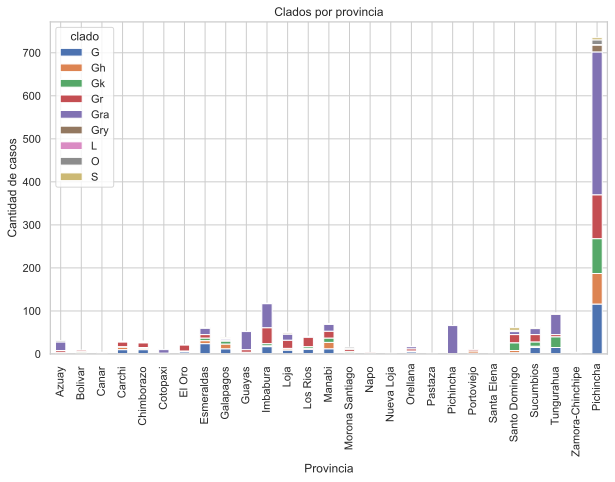

In [ ]:
grouped=df.groupby('provincia')['clado'].value_counts().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Clados por provincia')
ax.set_xlabel('Provincia')
ax.set_ylabel('Cantidad de casos')
plt.show()

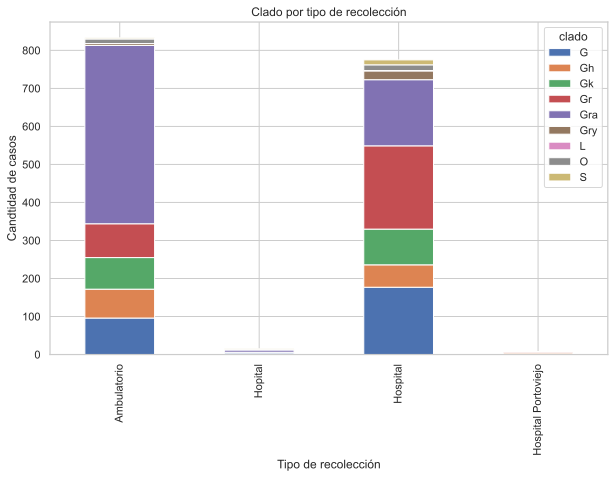

In [ ]:
grouped=df.groupby('tipo')['clado'].value_counts().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Clado por tipo de recolección')
ax.set_xlabel('Tipo de recolección')
ax.set_ylabel('Candtidad de casos')

plt.show()

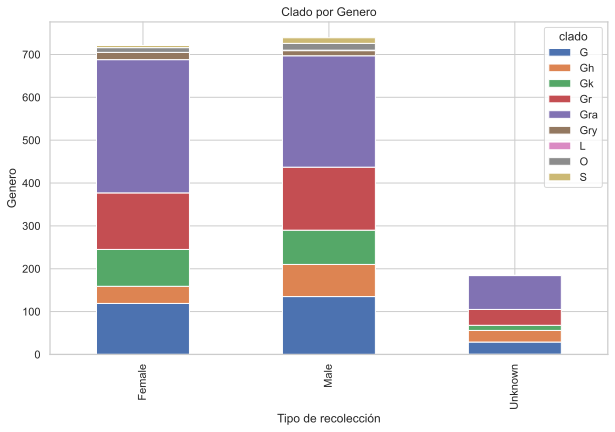

In [ ]:
grouped=df.groupby('genero')['clado'].value_counts().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Clado por Genero')
ax.set_xlabel('Tipo de recolección')
ax.set_ylabel('Genero')
plt.show()

In [ ]:
df.columns

Index(['provincia', 'ciudad', 'tipo', 'genero', 'edad', 'linaje', 'clado',
       '__E_A41V', '__E_L73F', '__E_R61L',
       ...
       '__Spike_Y145Del', '__Spike_Y145N', '__Spike_Y145P', '__Spike_Y145T',
       '__Spike_Y248Del', '__Spike_Y248F', '__Spike_Y449N', '__Spike_Y505H',
       'virus_name_unidentified', 'count_muts'],
      dtype='object', length=2010)

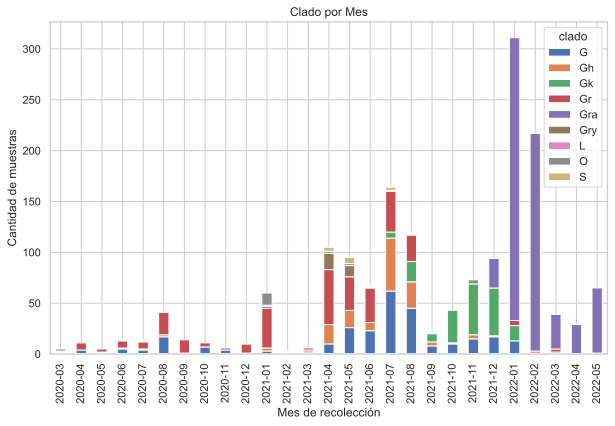

In [ ]:
df['anio_mes'] = df.index.to_period('M').strftime('%Y-%m')

grouped=df.groupby('anio_mes')['clado'].value_counts().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Clado por Mes')
ax.set_xlabel('Mes de recolección')
ax.set_ylabel('Cantidad de muestras')
plt.show()

In [ ]:
#Recolectar los linajes más frecuentes por mes en la provincia "Pichincha"

# Agrupar el DataFrame por mes y contar las variantes
grouped = df.groupby('anio_mes')['linaje'].value_counts()

# Recorrer cada mes y obtener las 5 variantes más comunes
top_5_variantes_por_mes = []
for mes, datos_mes in grouped.groupby(level=0):
    top_5_variantes = datos_mes.nlargest(2)
    top_5_variantes_por_mes.append(top_5_variantes)

# Combinar los resultados en un solo DataFrame
df_top_5_variantes = pd.concat(top_5_variantes_por_mes)

# Mostrar el DataFrame con las 5 variantes más comunes por m
df_top_5_variantes

anio_mes  linaje   
2020-03   B.1.14         2
          B.1.1          1
2020-04   B.1.1          5
          B.1            2
2020-05   B.1.1          3
          B.1.225        1
2020-06   B.1.1          7
          B.1            4
2020-07   B.1.1          7
          B.1.223        3
2020-08   B.1           15
          B.1.1         15
2020-09   B.1.1         12
          B.1.1.1        1
2020-10   B.1            7
          B.1.1          2
2020-11   B.1            4
          B.1.1          1
2020-12   B.1.1          5
          B.1.1.348      4
2021-01   B.1.1         16
          B             12
2021-02   B.1.1          2
          B.1            1
2021-03   B.1            2
          B.1.526        2
2021-04   B.1.1.7       30
          B.1.526       19
2021-05   B.1.1.7       28
          B.1           19
2021-06   B.1           19
          P.1           12
2021-07   B.1           46
          B.1.621       28
2021-08   B.1           40
          B.1.621       18
2021-09 

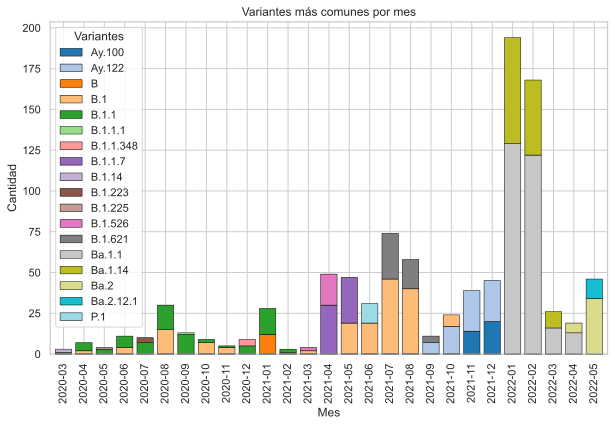

In [ ]:
# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))
df_top_5_variantes.unstack().plot(kind='bar', stacked=True, ax=ax, cmap='tab20', width=0.8, edgecolor='black', linewidth=0.5, legend=False,)

# Configurar los títulos y etiquetas de los ejes
ax.set_title('Variantes más comunes por mes')
ax.set_xlabel('Mes')
ax.set_ylabel('Cantidad')
ax.legend(title='Variantes')

# Mostrar el gráfico
plt.show()

ValueError: Unknown format code 'd' for object of type 'float'

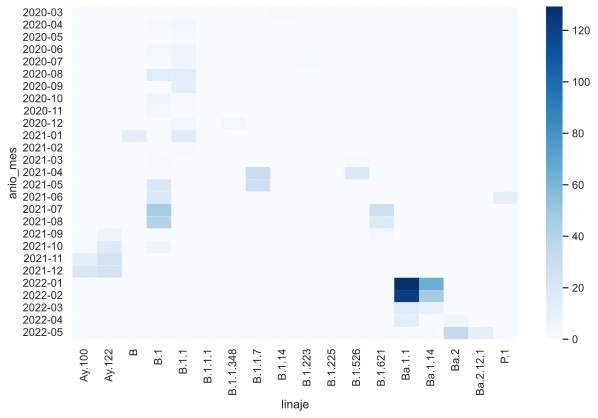

In [ ]:

# Crear una tabla pivote con los datos
tabla_pivote = df_top_5_variantes.unstack().fillna(0)

# Crear el gráfico de heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(tabla_pivote, cmap='Blues', annot=True, fmt='d', ax=ax)

# Configurar los títulos y etiquetas de los ejes
ax.set_title('Variantes más comunes por mes')
ax.set_xlabel('Variantes')
ax.set_ylabel('Mes')

# Mostrar el gráfico
plt.show()

### Anomalies

In [ ]:
# On June 5th 2020, for the column `positivas_pcr_nuevas` 
# there is a negative value
(cas_
 .loc['2020/05/06']
 ['positivas_pcr_nuevas']
)

-2498

In [ ]:
(cas_
 .loc['2020/05/08']
 ['positivas_pcr_nuevas']
)

-1480